In [237]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [238]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the Alpaca api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [239]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# api = tradeapi.REST()
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

In [240]:
type(alpaca_secret_key)

str

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [241]:
# Get all Asstes
assets = api.list_assets()

# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable ]
tradeable

[Asset({   'class': 'us_equity',
     'easy_to_borrow': True,
     'exchange': 'ARCA',
     'id': '3a64306e-4a77-4a06-8458-15a8bfd31f55',
     'marginable': True,
     'name': 'Vanguard Total Stock Market ETF',
     'shortable': True,
     'status': 'active',
     'symbol': 'VTI',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'ARCA',
     'id': '4ef5ad27-f4d8-42b5-8cbe-8abdd4af925a',
     'marginable': True,
     'name': 'Direxion Daily MSCI Brazil Bull 2X Shares',
     'shortable': False,
     'status': 'active',
     'symbol': 'BRZU',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'ARCA',
     'id': 'ef7cc734-f470-4448-931c-842fcc85f8b4',
     'marginable': True,
     'name': 'Direxion Daily Regional Banks Bull 3X Shares',
     'shortable': False,
     'status': 'active',
     'symbol': 'DPST',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_bor

In [242]:
# Create a new empty DataFrame
asset_info_df = pd.DataFrame()
asset_info_df['symbol'] = pd.Series([asset.symbol for asset in assets])

# Display the first 10 asset tickers
display(asset_info_df.head(10))

,symbol
0,CCA
1,CY
2,DEACU
3,VTI
4,GG
5,ORIT
6,OVOL
7,PGLC
8,PLND
9,PRB


In [243]:
tickers = ["SPY", "AGG"]
# YOUR CODE HERE
# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.head()

AGG                                          \
                             open     high       low    close      volume   
2019-01-02 00:00:00-05:00  106.55  106.610  106.4701  106.585  10164756.0   
2019-01-03 00:00:00-05:00  106.57  107.075  106.5700  107.020   6260265.0   
2019-01-04 00:00:00-05:00  106.66  106.720  106.5500  106.695   7755476.0   
2019-01-07 00:00:00-05:00  106.72  106.790  106.4600  106.470   6545877.0   
2019-01-08 00:00:00-05:00  106.40  106.530  105.5300  106.420   3818241.0   

                              SPY                                     
                             open    high     low   close     volume  
2019-01-02 00:00:00-05:00  245.98  251.21  245.95  249.89  107236613  
2019-01-03 00:00:00-05:00  248.23  248.57  244.03  244.46  113782919  
2019-01-04 00:00:00-05:00  247.59  253.11  247.17  252.41  122528832  
2019-01-07 00:00:00-05:00  252.69  255.95  251.69  254.40   88317608  
2019-01-08 00:00:00-05:00  256.82  257.31  254.00  256.65   88864452

In [244]:
# Use the `drop` function with the `level` parameter to drop extra columns in the multi-index DataFrame
df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
df.head()
df.index = df.index.date
df.head()

,AGG,SPY
,close,close
2019-01-02,106.585,249.89
2019-01-03,107.020,244.46
2019-01-04,106.695,252.41
2019-01-07,106.470,254.40
2019-01-08,106.420,256.65


In [245]:
df.tail()

,AGG,SPY
,close,close
2019-12-24,112.375,321.26
2019-12-26,112.480,322.91
2019-12-27,112.620,322.86
2019-12-30,112.630,321.10
2019-12-31,112.370,321.92


In [246]:
df.describe()

,AGG,SPY
,close,close
count,251.000000,252.000000
mean,110.462581,290.990570
std,2.423744,15.121681
min,106.325000,244.460000
25%,108.260000,281.485000
50%,111.130000,291.565000
75%,112.630000,299.884875
max,114.125000,322.910000


In [247]:
df.to_csv('2019ClosingPrices_AGG_SPY.csv')

# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [248]:
# Calculate the daily roi for the stocks
# YOUR CODE HERE
daily_returns = df.pct_change()
daily_returns.head()

,AGG,SPY
,close,close
2019-01-02,NaN,NaN
2019-01-03,0.004081,-0.021730
2019-01-04,-0.003037,0.032521
2019-01-07,-0.002109,0.007884
2019-01-08,-0.000470,0.008844


In [249]:
# Use the `mean` function to calculate the mean of daily returns for `AGG` and `SPY`, respectively
avg_daily_return_agg = daily_returns.mean()['AGG']['close']
avg_daily_return_agg

0.00021276976507473064

In [250]:
avg_daily_return_spy = daily_returns.mean()['SPY']['close']
avg_daily_return_spy

0.0010401250682146959

In [251]:
# Calculate volatility
# YOUR CODE HERE
std_dev_daily_return_agg = daily_returns.std()['AGG']['close']
std_dev_daily_return_agg

0.0020886019741764646

In [252]:
std_dev_daily_return_spy = daily_returns.std()['SPY']['close']
std_dev_daily_return_spy

0.007820053413439366

In [253]:
# Save the last day's closing price
# YOUR CODE HERE
agg_last_price = df['AGG']['close'][-1]
spy_last_price = df['SPY']['close'][-1]

In [254]:
agg_last_price

112.37

In [255]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()

simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

In [256]:
# Run the Monte Carlo Simulation
for x in range(number_simulations):
    
    # YOUR CODE HERE
     # Initialize the simulated prices list with the last closing price of `AGG` and `SPY`
    simulated_agg_prices = [agg_last_price]
    simulated_spy_prices = [spy_last_price]
    
    # Simulate the returns for 252 days
    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        
        # Append the simulated price to the list
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)
    
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (40% AGG; 60% SPY)
    weights = [0.40, 0.60]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[x] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000475,1.000537,0.998808,1.005395,1.011797,0.994452,0.997250,1.013277,1.000868,0.995376,...,1.002066,0.992709,1.001800,1.002671,0.996472,1.003160,1.001638,1.006801,0.998172,0.994766
2,1.008876,1.004700,1.003591,0.996711,1.009570,0.994247,0.994213,1.007201,1.000225,0.993035,...,1.005758,0.994517,1.003317,1.006181,0.997472,0.991774,1.002764,1.005409,0.996137,0.998871
3,1.008286,1.004228,1.003771,0.998233,1.007751,0.987669,0.998228,1.001363,1.000230,1.001277,...,1.006771,0.988443,1.004117,1.010565,0.993294,0.994454,1.008272,0.999144,0.998655,1.003329
4,1.013962,1.006575,1.008494,1.002636,1.013663,0.990972,1.003241,0.995493,1.002048,1.006035,...,1.004196,0.992122,1.004723,1.004422,0.994844,0.993782,1.005723,1.002248,0.996963,1.004095


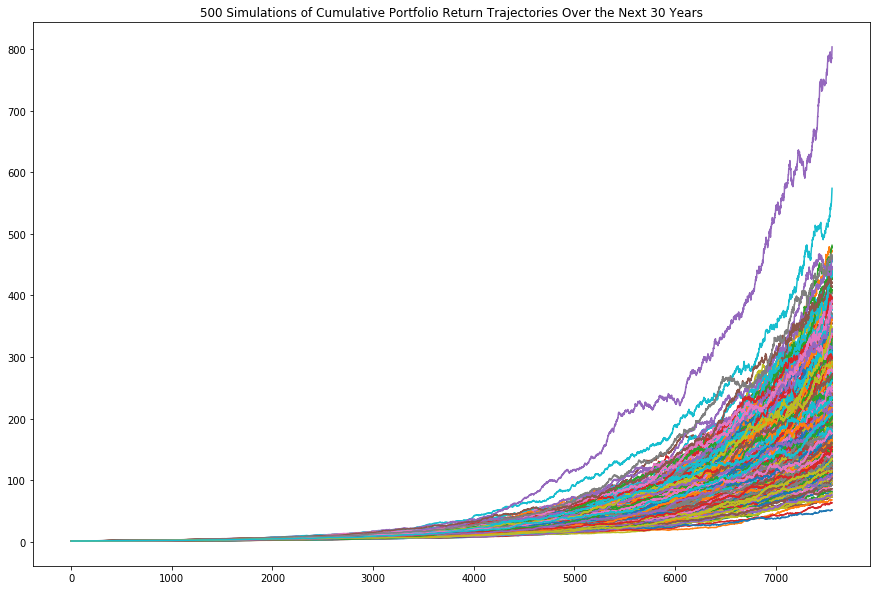

In [257]:
# Visualize the Simulation
# YOUR CODE HERE
plot_title = f"{x+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 30 Years"
portfolio_cumulative_returns.plot(legend=None, title=plot_title, figsize=(15,10))

In [258]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
# YOUR CODE HERE
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    192.769939
1    171.963857
2    177.992293
3    138.460439
4    175.622694
Name: 7560, dtype: float64

In [259]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
# YOUR CODE HERE
ending_cumulative_returns_20yrs = portfolio_cumulative_returns.iloc[-5040, :]
ending_cumulative_returns_20yrs.head()

0    6.701849
1    8.580609
2    4.848236
3    4.420025
4    8.839552
Name: 2521, dtype: float64

In [260]:
# Display the 90% confidence interval for the ending returns
# YOUR CODE HERE
confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval

0.05    102.825245
0.95    379.342101
Name: 7560, dtype: float64

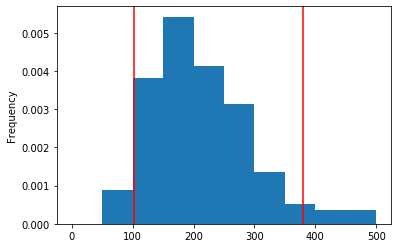

In [261]:
# Visualize the distribution of the ending returns
# YOUR CODE HEREplt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=[0,50,100,150,200,250,300,350,400,500])
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [262]:
# YOUR CODE HERE
expected_cumulative_returns=ending_cumulative_returns.quantile(q=[0.1, 0.5, 0.9])
expected_cumulative_returns

0.1    119.029858
0.5    199.089970
0.9    320.549831
Name: 7560, dtype: float64

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [263]:
initial_investment = 20000

# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
expected_return_10th_percentil = initial_investment + (initial_investment * expected_cumulative_returns.iloc[0])
expected_return_50th_percentil = initial_investment + (initial_investment * expected_cumulative_returns.iloc[1])
expected_return_90th_percentil = initial_investment + (initial_investment * expected_cumulative_returns.iloc[2])                                                    

print(f"Expected return in dollars of an initial investment of $20,000 in the portfolio\n"
      f" at the 10th percentile: ${int(expected_return_10th_percentil):,d}\n"
      f" at the 50th percentile: ${int(expected_return_50th_percentil):,d}\n"
      f" at the 90th percentile: ${int(expected_return_90th_percentil):,d}")

Expected return in dollars of an initial investment of $20,000 in the portfolio
 at the 10th percentile: $2,400,597
 at the 50th percentile: $4,001,799
 at the 90th percentile: $6,430,996


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [264]:
# YOUR CODE HERE
projected_yearly_income_before_tax = 7389
expected_return_withdrawing4pct = .04 * (initial_investment * ending_cumulative_returns.quantile(.1))
if expected_return_withdrawing4pct > projected_yearly_income_before_tax:
    print(f"Expected return ${round(expected_return_withdrawing4pct,2)} > projected annual income from Plaid = $7389")
else:   
    print(f"Expected return ${round(expected_return_withdrawing4pct,2)} > projected annual income from Plaid = $7389")

Expected return $95223.89 > projected annual income from Plaid = $7389


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [265]:
# YOUR CODE HERE
new_investment = initial_investment * 1.5
new_investment

30000.0

In [266]:
expected_return_10th_percentil_new_investment = new_investment + (new_investment * expected_cumulative_returns.iloc[0])
expected_return_50th_percentil_new_investment = new_investment + (new_investment * expected_cumulative_returns.iloc[1])
expected_return_90th_percentil_new_investment = new_investment + (new_investment * expected_cumulative_returns.iloc[2])

print(f"Expected return in dollars of an investment of $30,000 in the portfolio\n"
      f" at the 10th percentile: ${int(expected_return_10th_percentil_new_investment):,d}\n"
      f" at the 50th percentile: ${int(expected_return_50th_percentil_new_investment):,d}\n"
      f" at the 90th percentile: ${int(expected_return_90th_percentil_new_investment):,d}")

Expected return in dollars of an investment of $30,000 in the portfolio
 at the 10th percentile: $3,600,895
 at the 50th percentile: $6,002,699
 at the 90th percentile: $9,646,494


In [267]:
expected_return_withdrawing_4pct_new_investment = new_investment * ending_cumulative_returns.quantile(.1)
if expected_return_withdrawing_4pct_new_investment > projected_yearly_income_before_tax:
    print(f"Expected return ${round(expected_return_withdrawing_4pct_new_investment,2)} > projected annual income from Plaid = $7389")
else:   
    print(f"Expected return ${round(expected_return_withdrawing_4pct_new_investment,2)} > projected annual income from Plaid = $7389")

Expected return $3570895.74 > projected annual income from Plaid = $7389


A 50% in the initial investment will increase the expected return of the 4% withdrawal at the 10 percentile

### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

## Optional Challenge — Early Retirement

In [227]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 5
monte_carlo = pd.DataFrame()

simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

In [228]:
# Run the Monte Carlo Simulation
for x in range(number_simulations):
    
    # YOUR CODE HERE
     # Initialize the simulated prices list with the last closing price of `AGG` and `SPY`
    simulated_agg_prices = [agg_last_price]
    simulated_spy_prices = [spy_last_price]
    
    # Simulate the returns for 252 days
    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        
        # Append the simulated price to the list
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)
    
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (20% AGG; 80% SPY)
    weights = [0.20, 8.0]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[x] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.953125,0.958175,0.982391,0.964797,1.005679,1.050453,0.985430,1.029860,0.999214,0.892735,...,0.949301,1.089366,1.051599,0.980671,0.969780,1.061853,1.073079,1.006126,0.910280,0.981612
2,0.988389,0.930962,1.111566,1.054650,1.127660,1.158499,1.002228,1.028919,1.048001,0.768384,...,0.945592,1.013040,1.102276,0.982244,0.980580,1.209857,1.053055,0.996966,0.927513,0.991872
3,0.923513,0.991518,1.208747,0.983550,1.044171,1.250205,0.976441,1.027952,1.082268,0.692323,...,0.964248,0.956872,1.146686,0.862200,0.956459,1.254400,1.137187,0.961154,1.010111,1.095161
4,1.013690,0.944886,1.245137,0.982556,1.167546,1.215366,0.934639,0.981989,1.120135,0.654725,...,0.880595,0.937600,1.011015,0.720863,0.890706,1.236274,1.081091,0.951197,1.057962,1.108968


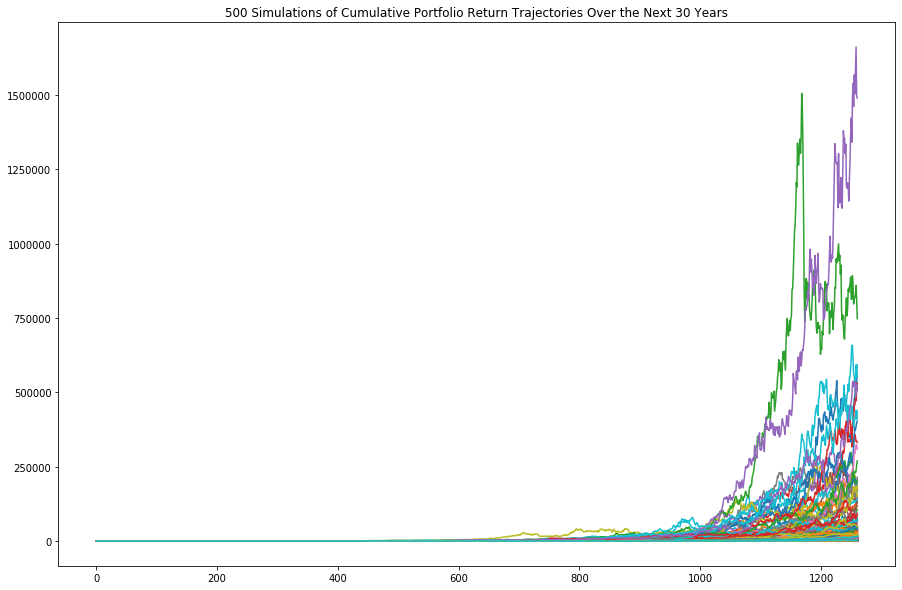

In [229]:
plot_title = f"{x+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 30 Years"
portfolio_cumulative_returns.plot(legend=None, title=plot_title, figsize=(15,10))

In [230]:
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0     2352.407396
1      528.749823
2     3024.367832
3    21387.573038
4     1365.896400
Name: 1260, dtype: float64

In [231]:
confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval

0.05        69.195564
0.95    118898.239547
Name: 1260, dtype: float64